In [1]:
from IPython.display      import Image

import matplotlib.pyplot  as plt
import tensorflow         as tf
import numpy              as np

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Dataset import

In [3]:
dataset = np.load("proyecto_training_data.npy")
dataset = dataset[:, 0:2]

In [4]:
x = dataset[:, 1]
y = dataset[:, 0]

## Model graph

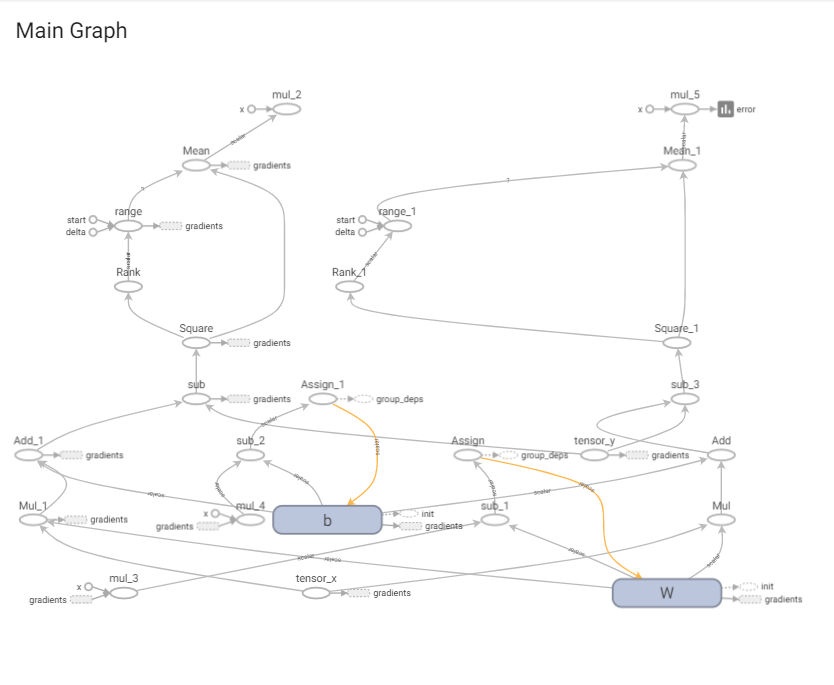

In [5]:
Image("grafo.png")

## Model Class

In [6]:
class ModeloLineal:
    def __init__(self):
        tf.reset_default_graph()
        self.W = tf.get_variable("W", dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
        self.b = tf.get_variable("b", dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
        

    def predict(self, x):
        return tf.add(tf.multiply(self.W, x), self.b)

    def update(self, x, y, learning_rate):
        prediction = self.predict(x)
        error = .5 * tf.reduce_mean(tf.math.square(y - prediction))
        gradient = tf.gradients(error, [self.W, self.b])
        updatew = tf.assign(self.W, self.W - learning_rate * gradient[0] )
        updateb = tf.assign(self.b, self.b - learning_rate * gradient[1] )
        update_params = tf.group(updatew, updateb)
        return update_params
    
    def mini_batches(self, x, y, batch_size):
        for batch_iteration in range(int(len(x)/batch_size)):
            init_batch = batch_iteration * batch_size
            end_batch = init_batch + batch_size
            yield np.array(x[init_batch:end_batch].reshape([-1,1])), np.array(y[init_batch:end_batch].reshape([-1,1]))
            
    def parse_config(self, config_string):
        parameters = {}
        for conf in config_string.split('_')[1:]:
            parameters[conf.split('=')[0]] = conf.split('=')[1]
        return parameters
        
    def train(self, x, y, conf_string):
        config = self.parse_config(conf_string)
        lr = float(config['lr'])
        epochs = int(config['epochs'])
        batch_size = int(config['batchsize'])
        log_epoch = int(config['logepoch'])
        
        tensor_x = tf.placeholder("float", name="tensor_x")
        tensor_y = tf.placeholder("float", name="tensor_y")
        
        prediction = self.predict(tensor_x)
        update_params = self.update(tensor_x, tensor_y, lr)
        error = .5 * tf.reduce_mean(tf.math.square(tensor_y - prediction))
        error_sum = tf.summary.scalar("Error", error)
        init = tf.global_variables_initializer()
        
        with tf.Session() as session:
            writer = tf.summary.FileWriter(f'./experimentos/{conf_string}', session.graph)
            session.run(init)
            for epoch in range(epochs):
                for mini_x, mini_y in self.mini_batches(x, y, batch_size):
                    feed_dict = {tensor_x: mini_x, tensor_y: mini_y}    
                    session.run(update_params, feed_dict=feed_dict)
                    predictions = session.run(prediction, feed_dict=feed_dict)
                    
                if (epoch % log_epoch == 0):
                    w_value = session.run(self.W)
                    b_value = session.run(self.b)
                    error_value = session.run(error, feed_dict={tensor_x : x, tensor_y : y})
                    print(f"Epoch: {epoch}, W: {w_value}, b: {b_value}, error: {error_value}")
                    writer.add_summary(session.run(error_sum, feed_dict= {tensor_x : x, tensor_y : y}), epoch)

In [7]:
modelo = ModeloLineal()

## Experimento 1

Hipotesis

El modelo con pocas iteraciones sobre un tamano de batch pequeno no deberia corregir su error por mas del 1 %

In [8]:
configuration_string = "linearregression_epochs=10_lr=0.001_batchsize=16_logepoch=1"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 28875.8359375, b: 4045.826171875, error: 1442830080.0
Epoch: 1, W: 29640.064453125, b: 3718.03125, error: 1425326976.0
Epoch: 2, W: 29724.962890625, b: 3286.436767578125, error: 1423083392.0
Epoch: 3, W: 29793.171875, b: 2854.173828125, error: 1420980096.0
Epoch: 4, W: 29860.681640625, b: 2423.723876953125, error: 1418897792.0
Epoch: 5, W: 29927.89453125, b: 1995.142822265625, error: 1416833792.0
Epoch: 6, W: 29994.8125, b: 1568.420166015625, error: 1414787840.0
Epoch: 7, W: 30061.443359375, b: 1143.5489501953125, error: 1412759040.0
Epoch: 8, W: 30127.78125, b: 720.5215454101562, error: 1410748160.0
Epoch: 9, W: 30193.8359375, b: 299.3303527832031, error: 1408754432.0


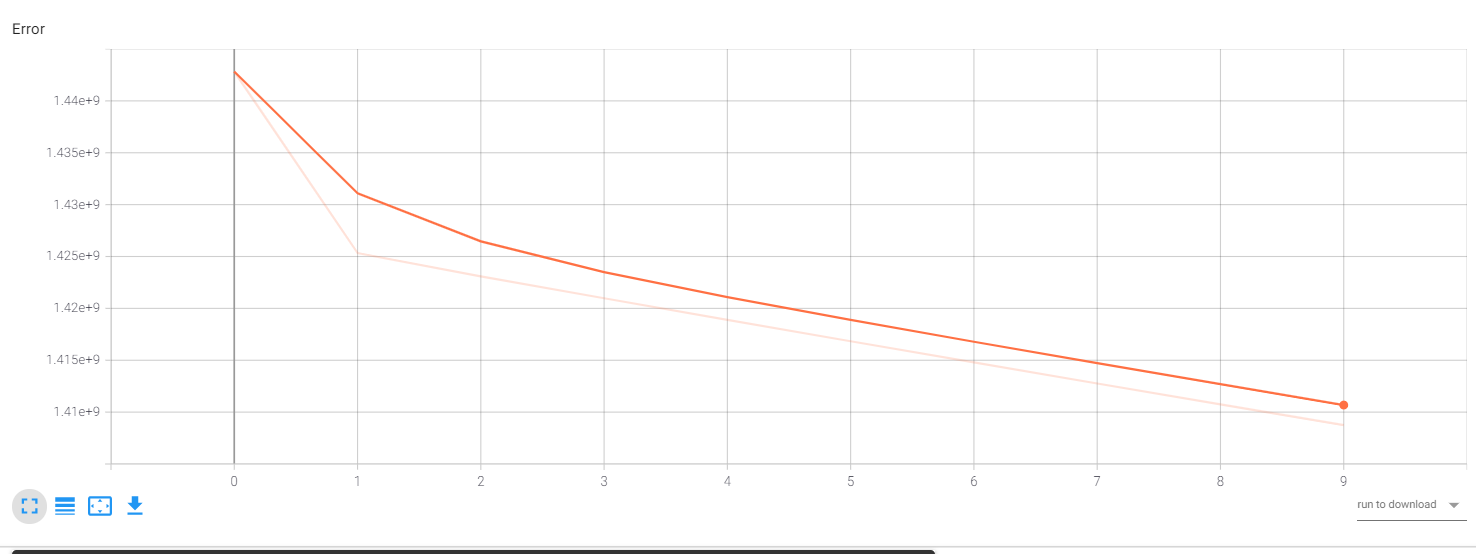

In [21]:
Image("exp1.png")

## Experimento 2

Hipotesis
Al aumentar los epochs y el batchsize, el modelo deberia ser capaz de mostrar mucho mejor rendimiento en cuanto a minimizar su error dado que el batchsize mas grande lo hace mas general.

In [9]:
configuration_string = "linearregression_epochs=100_lr=0.001_batchsize=32_logepoch=10"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 24983.46875, b: 3668.28515625, error: 1889507968.0
Epoch: 10, W: 30028.892578125, b: 2252.36181640625, error: 1417386880.0
Epoch: 20, W: 30358.361328125, b: 148.74212646484375, error: 1407370240.0
Epoch: 30, W: 30680.82421875, b: -1910.1695556640625, error: 1397776512.0
Epoch: 40, W: 30996.435546875, b: -3925.325439453125, error: 1388587008.0
Epoch: 50, W: 31305.345703125, b: -5897.65673828125, error: 1379785472.0
Epoch: 60, W: 31607.6796875, b: -7828.072265625, error: 1371354624.0
Epoch: 70, W: 31903.591796875, b: -9717.4658203125, error: 1363279488.0
Epoch: 80, W: 32193.216796875, b: -11566.7001953125, error: 1355545344.0
Epoch: 90, W: 32476.689453125, b: -13376.626953125, error: 1348137088.0


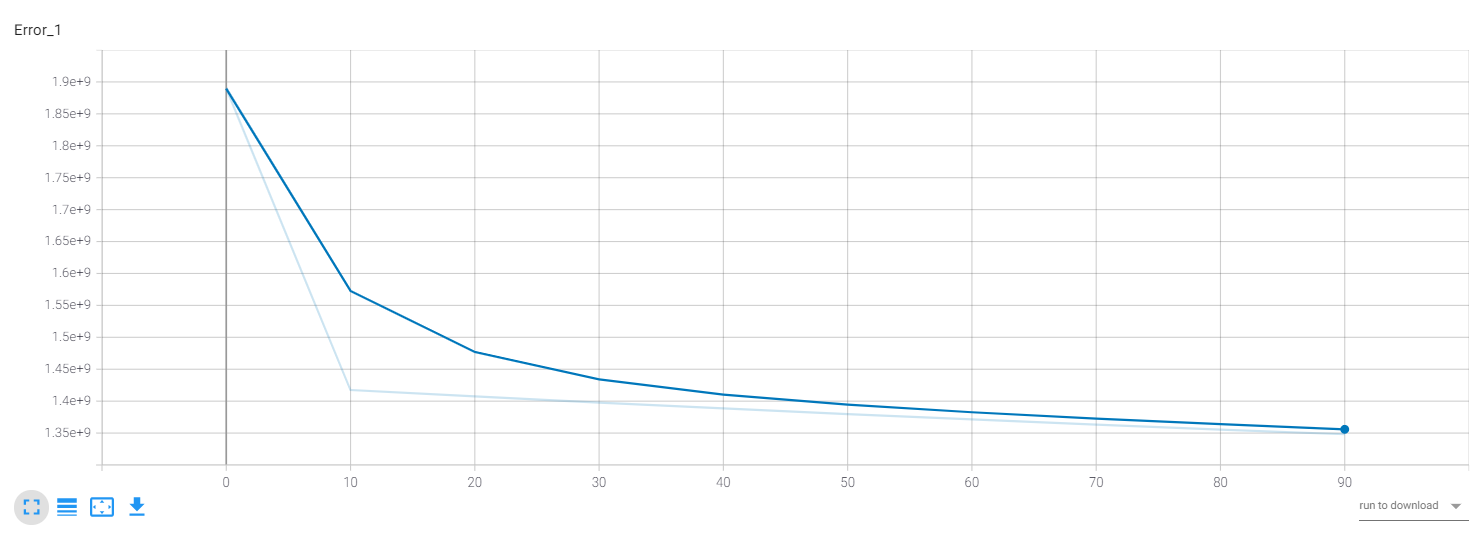

In [23]:
Image("exp2.png")

## Experimento 3



In [10]:
configuration_string = "linearregression_epochs=100_lr=0.001_batchsize=16_logepoch=10"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 28875.8359375, b: 4045.826171875, error: 1442830080.0
Epoch: 10, W: 30259.59765625, b: -120.03302001953125, error: 1406778752.0
Epoch: 20, W: 30901.755859375, b: -4214.8818359375, error: 1387933952.0
Epoch: 30, W: 31516.587890625, b: -8135.46875, error: 1370659584.0
Epoch: 40, W: 32105.248046875, b: -11889.203125, error: 1354824704.0
Epoch: 50, W: 32668.869140625, b: -15483.208984375, error: 1340309248.0
Epoch: 60, W: 33208.484375, b: -18924.2578125, error: 1327003776.0
Epoch: 70, W: 33725.15625, b: -22218.841796875, error: 1314806528.0
Epoch: 80, W: 34219.83203125, b: -25373.2734375, error: 1303626368.0
Epoch: 90, W: 34693.453125, b: -28393.4375, error: 1293377408.0


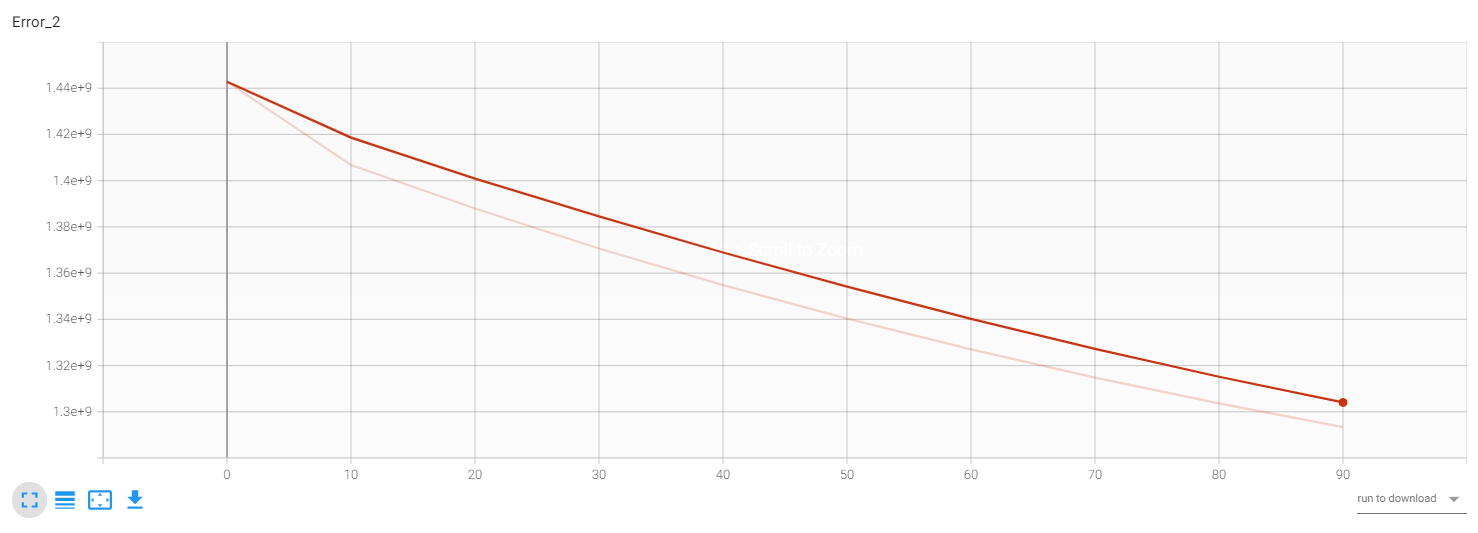

In [24]:
Image("exp3.png")

## Experimento 4


In [11]:
configuration_string = "linearregression_epochs=1000_lr=0.001_batchsize=16_logepoch=100"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 28875.8359375, b: 4045.826171875, error: 1442830080.0
Epoch: 100, W: 35146.93359375, b: -31285.0859375, error: 1283982336.0
Epoch: 200, W: 38744.87109375, b: -54228.12890625, error: 1223933568.0
Epoch: 300, W: 41073.98046875, b: -69080.1640625, error: 1198785536.0
Epoch: 400, W: 42581.65234375, b: -78694.125, error: 1188257536.0
Epoch: 500, W: 43557.67578125, b: -84917.9921875, error: 1183852160.0
Epoch: 600, W: 44189.515625, b: -88947.0, error: 1182010368.0
Epoch: 700, W: 44598.53515625, b: -91555.25, error: 1181241344.0
Epoch: 800, W: 44863.3046875, b: -93243.546875, error: 1180920448.0
Epoch: 900, W: 45034.734375, b: -94336.703125, error: 1180787200.0


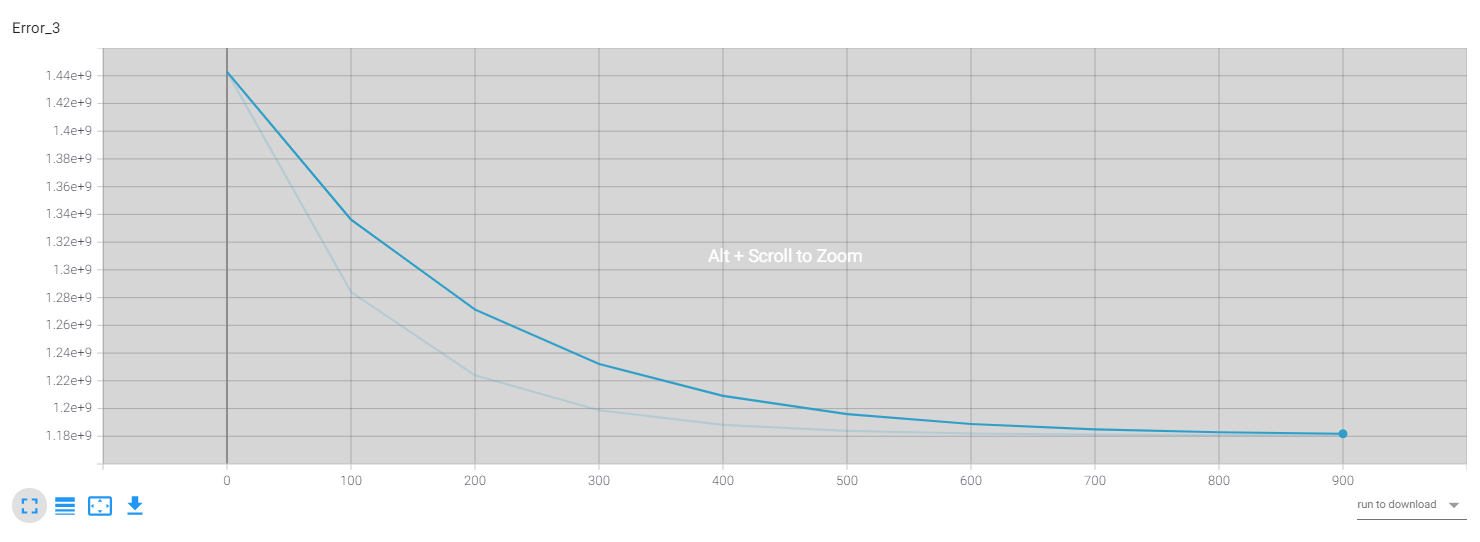

In [25]:
Image("exp4.png")

## Experimento 5



In [12]:
configuration_string = "linearregression_epochs=1000_lr=0.01_batchsize=16_logepoch=100"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 29543.5, b: 106.87887573242188, error: 1422031616.0
Epoch: 100, W: 44662.1171875, b: -95252.6484375, error: 1188128768.0
Epoch: 200, W: 44855.98828125, b: -96475.46875, error: 1188030976.0
Epoch: 300, W: 44858.4375, b: -96490.90625, error: 1188029824.0
Epoch: 400, W: 44858.4609375, b: -96491.078125, error: 1188029568.0
Epoch: 500, W: 44858.4609375, b: -96491.078125, error: 1188029568.0
Epoch: 600, W: 44858.4609375, b: -96491.078125, error: 1188029568.0
Epoch: 700, W: 44858.4609375, b: -96491.078125, error: 1188029568.0
Epoch: 800, W: 44858.4609375, b: -96491.078125, error: 1188029568.0
Epoch: 900, W: 44858.4609375, b: -96491.078125, error: 1188029568.0


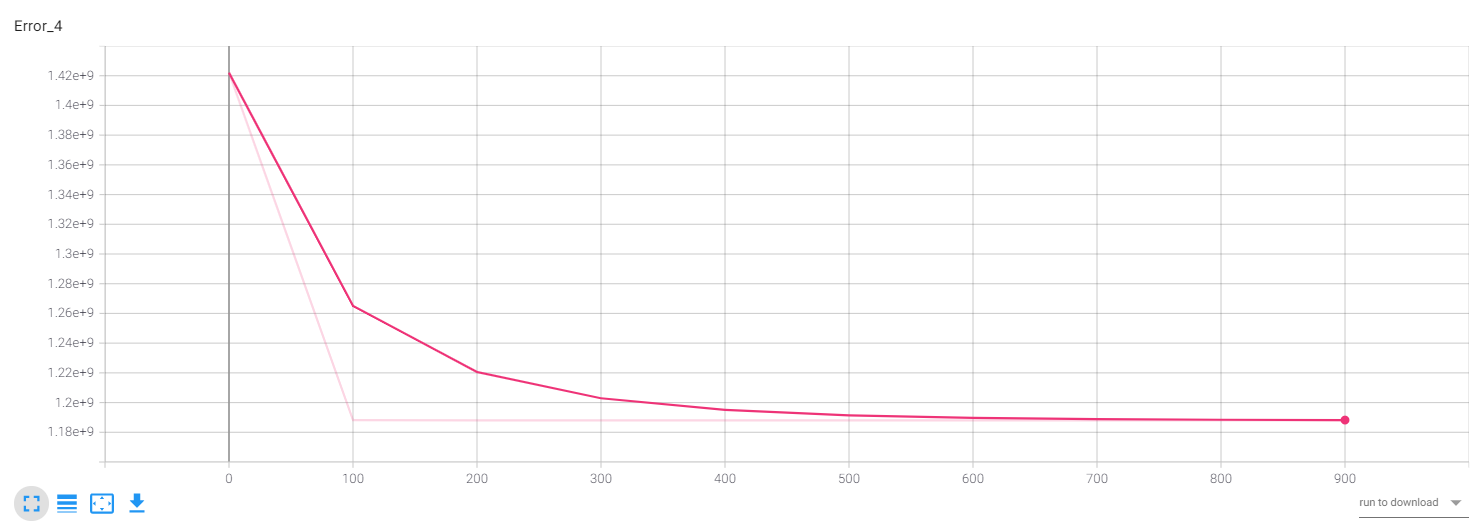

In [26]:
Image("exp5.png")

## Experimento 6


In [13]:
configuration_string = "linearregression_epochs=1000_lr=0.001_batchsize=64_logepoch=100"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 17637.5078125, b: 2638.437255859375, error: 4418639872.0
Epoch: 100, W: 31262.25390625, b: -5630.03759765625, error: 1380970624.0
Epoch: 200, W: 32687.26171875, b: -14759.451171875, error: 1342595584.0
Epoch: 300, W: 33969.6796875, b: -22975.314453125, error: 1311542144.0
Epoch: 400, W: 35123.765625, b: -30369.03125, error: 1286416512.0
Epoch: 500, W: 36162.359375, b: -37022.82421875, error: 1266089216.0
Epoch: 600, W: 37097.03125, b: -43010.85546875, error: 1249645696.0
Epoch: 700, W: 37938.171875, b: -48399.6953125, error: 1236345216.0
Epoch: 800, W: 38695.1484375, b: -53249.234375, error: 1225589248.0
Epoch: 900, W: 39376.3671875, b: -57613.56640625, error: 1216891776.0


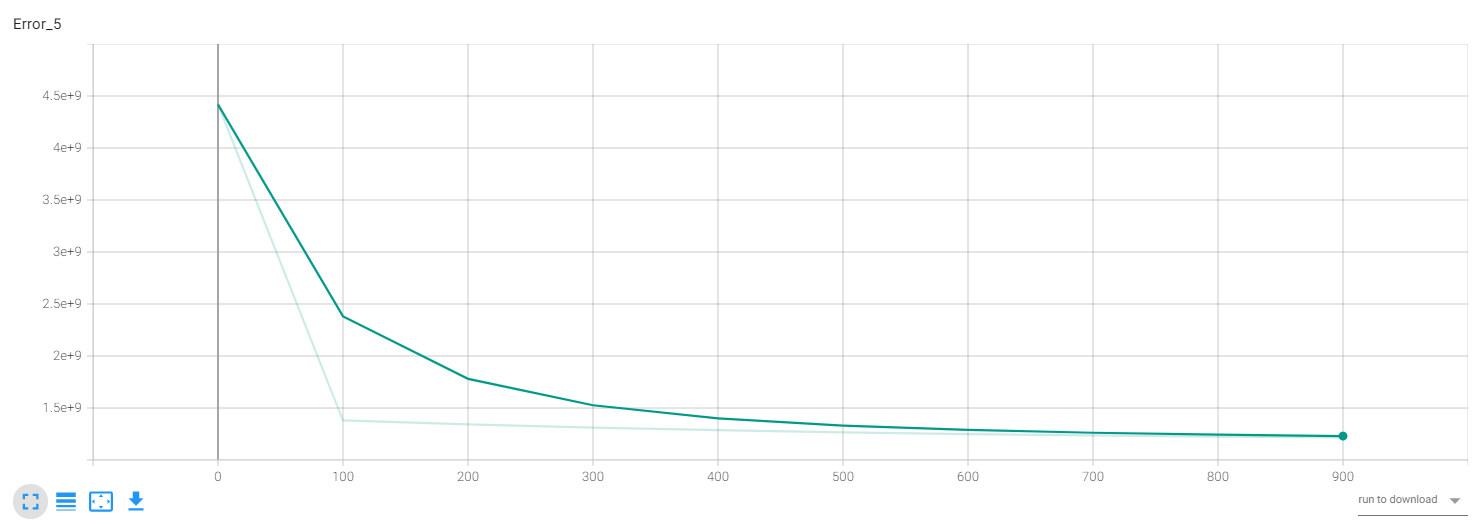

In [27]:
Image("exp6.png")

## Experimento 7



In [14]:
configuration_string = "linearregression_epochs=1000_lr=0.001_batchsize=128_logepoch=100"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 10780.17578125, b: 1625.701904296875, error: 8774353920.0
Epoch: 100, W: 30507.505859375, b: -633.578857421875, error: 1403661312.0
Epoch: 200, W: 31278.279296875, b: -5574.0146484375, error: 1381183104.0
Epoch: 300, W: 32009.47265625, b: -10260.775390625, error: 1360962048.0
Epoch: 400, W: 32703.125, b: -14706.896484375, error: 1342771200.0
Epoch: 500, W: 33361.16015625, b: -18924.728515625, error: 1326407168.0
Epoch: 600, W: 33985.3984375, b: -22925.958984375, error: 1311687296.0
Epoch: 700, W: 34577.59375, b: -26721.751953125, error: 1298446080.0
Epoch: 800, W: 35139.37109375, b: -30322.640625, error: 1286535808.0
Epoch: 900, W: 35672.30859375, b: -33738.61328125, error: 1275822592.0


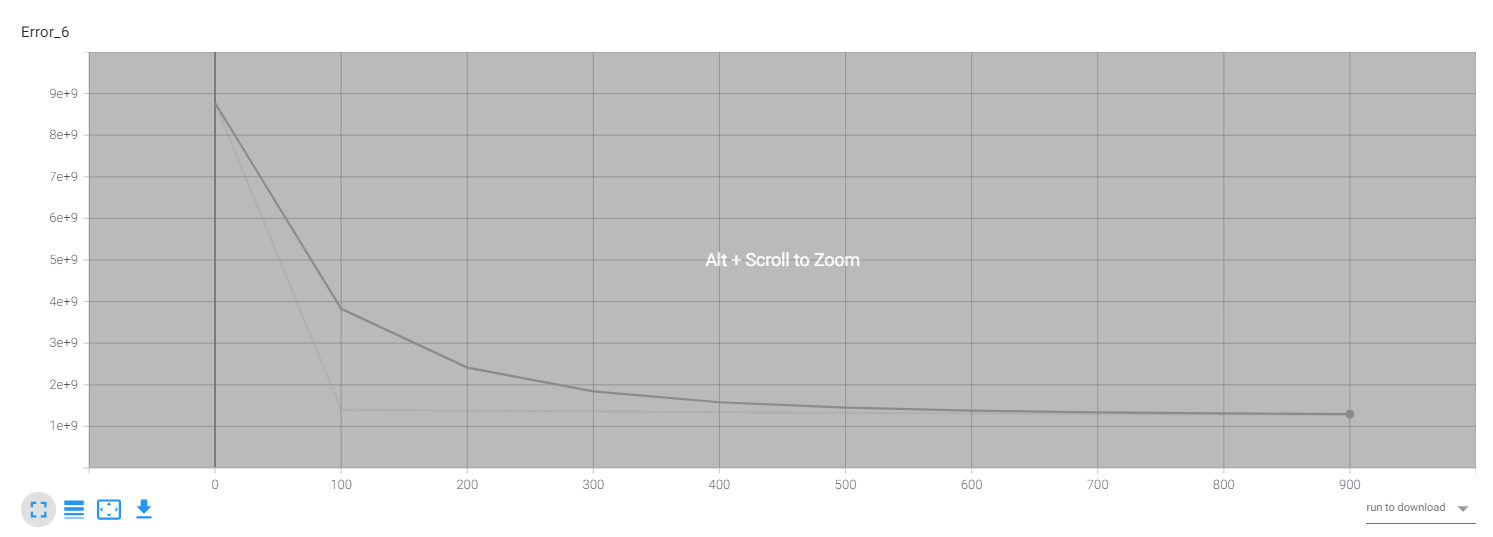

In [28]:
Image("exp7.png")

## Experimento 8


In [15]:
configuration_string = "linearregression_epochs=2000_lr=0.001_batchsize=256_logepoch=200"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 5508.5224609375, b: 834.0210571289062, error: 13433517056.0
Epoch: 200, W: 30515.31640625, b: -251.40231323242188, error: 1405473408.0
Epoch: 400, W: 31240.421875, b: -4894.75341796875, error: 1384228736.0
Epoch: 600, W: 31931.943359375, b: -9323.013671875, error: 1364950016.0
Epoch: 800, W: 32591.427734375, b: -13546.15234375, error: 1347457024.0
Epoch: 1000, W: 33220.3671875, b: -17573.6875, error: 1331585920.0
Epoch: 1200, W: 33820.171875, b: -21414.64453125, error: 1317188736.0
Epoch: 1400, W: 34392.19921875, b: -25077.7109375, error: 1304130048.0
Epoch: 1600, W: 34937.72265625, b: -28571.1015625, error: 1292286848.0
Epoch: 1800, W: 35457.99609375, b: -31902.71484375, error: 1281547904.0


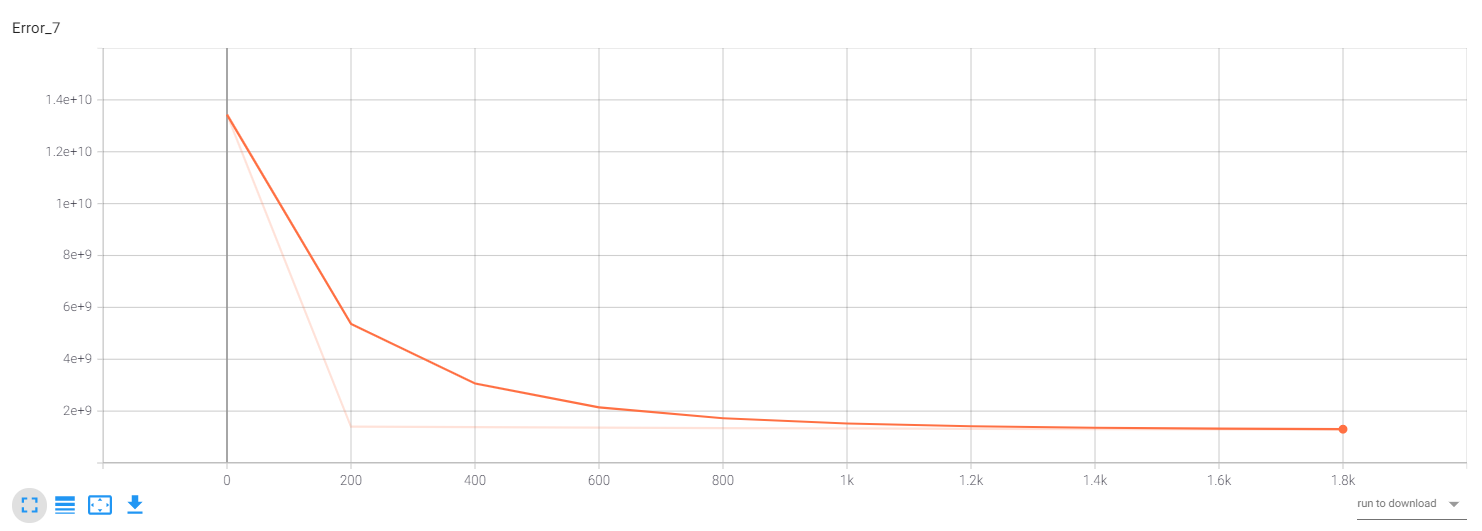

In [29]:
Image("exp8.png")

## Experimento 9


In [16]:
configuration_string = "linearregression_epochs=1000_lr=0.01_batchsize=256_logepoch=100"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 27486.880859375, b: 4024.453857421875, error: 1531094784.0
Epoch: 100, W: 33256.5546875, b: -17770.21875, error: 1330842112.0
Epoch: 200, W: 35998.92578125, b: -35241.65234375, error: 1271375360.0
Epoch: 300, W: 38161.89453125, b: -49021.765625, error: 1235004032.0
Epoch: 400, W: 39867.875, b: -59890.4296875, error: 1212868352.0
Epoch: 500, W: 41213.4140625, b: -68462.75, error: 1199484928.0
Epoch: 600, W: 42274.6640625, b: -75223.8984375, error: 1191464832.0
Epoch: 700, W: 43111.6875, b: -80556.5, error: 1186715776.0
Epoch: 800, W: 43771.8671875, b: -84762.46875, error: 1183951232.0
Epoch: 900, W: 44292.58203125, b: -88079.8828125, error: 1182381312.0


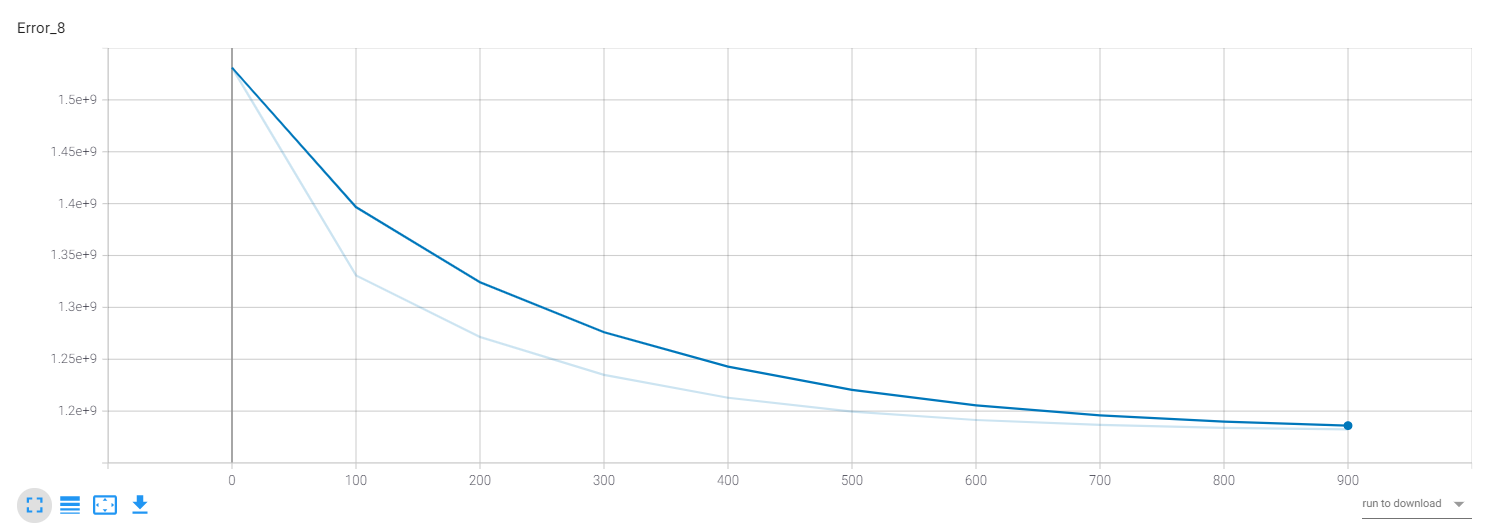

In [30]:
Image("exp9.png")

## Experimento 10

Hipotesis

Entre mas se parece el metodo de optimizcion al stochastic gradient decent mas prometedor sera el ajuste.

In [17]:
configuration_string = "linearregression_epochs=10000_lr=0.001_batchsize=256_logepoch=1000"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 5508.5224609375, b: 834.0210571289062, error: 13433517056.0
Epoch: 1000, W: 33220.3671875, b: -17573.6875, error: 1331585920.0
Epoch: 2000, W: 35954.15625, b: -35079.96484375, error: 1271811712.0
Epoch: 3000, W: 38110.78125, b: -48890.35546875, error: 1235225088.0
Epoch: 4000, W: 39812.11328125, b: -59785.15625, error: 1212939392.0
Epoch: 5000, W: 41154.2734375, b: -68379.8203125, error: 1199451776.0
Epoch: 6000, W: 42213.0625, b: -75160.0703125, error: 1191358336.0
Epoch: 7000, W: 43048.3359375, b: -80508.8125, error: 1186559232.0
Epoch: 8000, W: 43707.2578125, b: -84728.328125, error: 1183759744.0
Epoch: 9000, W: 44227.06640625, b: -88057.03125, error: 1182164992.0


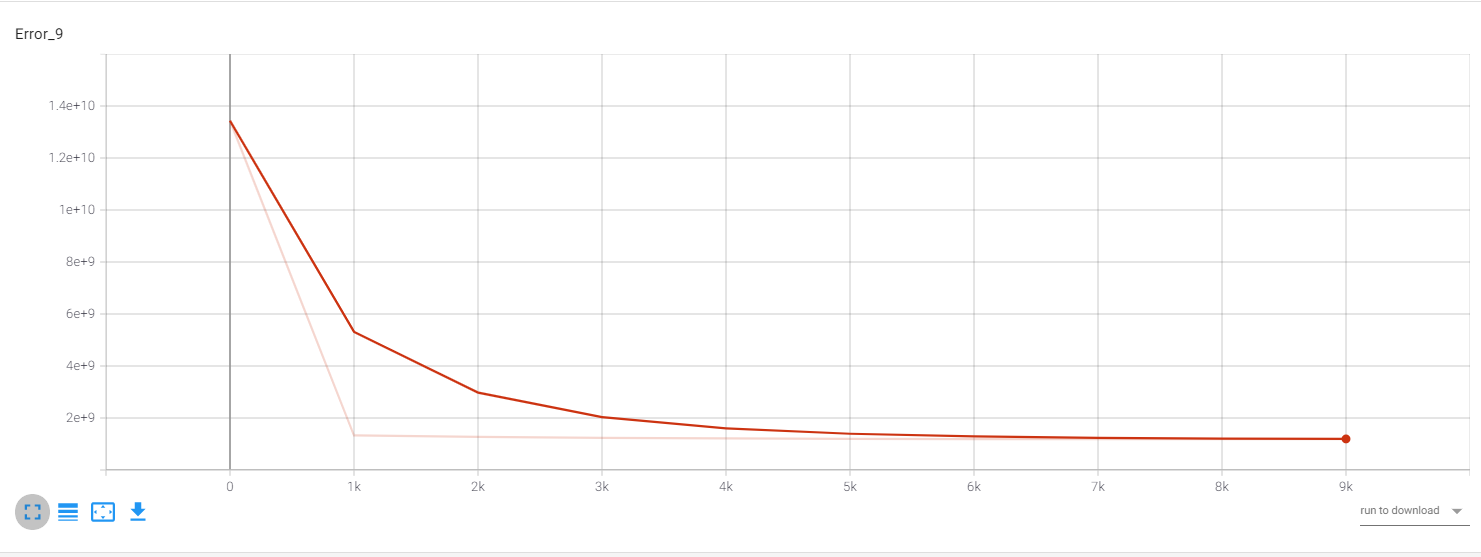

In [31]:
Image("exp10.png")

## Conclusion

Como era de esperarse, el modelo empieza a ajustarse cada vez mejor, el mini batch cuando es muy pequeno tiende a no ajustar muy bien pues cuando mas grande es el batch es como si estuviera entrenandose y ajustandose sobre todo el dataset, mientras que si es pequeno pues realiza optimizciones mas o menos locales para los registros que tenia el minibatch. El learning rate hasta cierto punto ayudo a que fuera algo pequeno, pero cuando llega a un nivel en donde no disminiye demasiado el error, deberia porderse ajustar o modificar ese learning rate para quesaltar un poco mas y ya hacer un ajuste mas minucioso.